# Confirm XYZeq Corresponding Cell Types Have Similar Gene Sets

Before generating more figures in the paper, I would like to see which cell types in each dataset "correspond" to each other — are we seeing the same cell types, and same genes being expressed in those cell types? This can help us narrow down to a handful of cell types for generating the rest of the figures.

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import pickle as pkl
import os
from copy import copy
import warnings
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import seaborn as sns

import json
import requests
# from IPython.display import display, HTML
# import bbknn
import time

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [3]:
prefix = '/data/xyzeq/'

### Load in the data

In [4]:
with open('/data/xyzeq/10x/5prime_liver/downsample/10x.down.pkl','rb') as file:
    adata_10x = pkl.load(file)['mouse_down']

In [5]:
adata_xyz = sc.read_h5ad(prefix + 'box.data4/all_batches_mouse_only_processed.h5ad')

In [6]:
print(adata_10x.obs.columns)
print(adata_xyz.obs.columns)

Index(['mouse_counts', 'human_counts', 'percent_mito', 'n_counts', 'leiden',
       'celltype'],
      dtype='object')
Index(['batch', 'n_counts', 'log_counts', 'n_genes', 'barcode',
       'percent_mito_mouse', 'percent_mito_human', 'mouse_counts',
       'human_counts', 'ratio', 'cell_call', 'contam_init', 'tsne_density',
       'leiden', 'CellType', '__is_in_cluster__'],
      dtype='object')


In [16]:
print(adata_10x.var_names)
print(adata_xyz.var_names)

Index(['Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20', 'Atp6v1h', 'Rb1cc1', 'Pcmtd1',
       'Rrs1', 'Adhfe1', 'Vcpip1',
       ...
       'mt-Nd6', 'mt-Cytb', 'Vamp7', 'AC133103.1', 'Csprs', 'AC168977.2',
       'AC168977.1', 'AC149090.1', 'CAAA01118383.1', 'CAAA01147332.1'],
      dtype='object', length=9776)
Index(['mm10_Rims1', 'mm10_Lmbrd1', 'mm10_Il18r1', 'mm10_Dnah7b', 'mm10_Stat4',
       'mm10_Adam23', 'mm10_Erbb4', 'mm10_Spag16', 'mm10_Xrcc5', 'mm10_Igfbp2',
       ...
       'mm10_Cyp2c50', 'mm10_Cyp2c70', 'mm10_Hoga1', 'mm10_Fam178a',
       'mm10_Sema4g', 'mm10_Wbp1l', 'mm10_Xpnpep1', 'mm10_Mxi1', 'mm10_Acsl5',
       'mm10_Rab11fip2'],
      dtype='object', length=764)


### Visualize

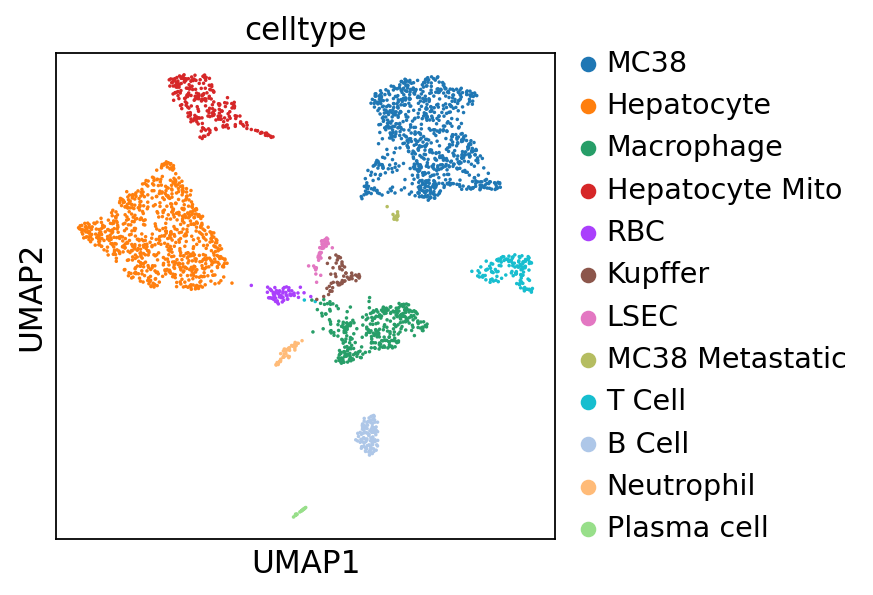

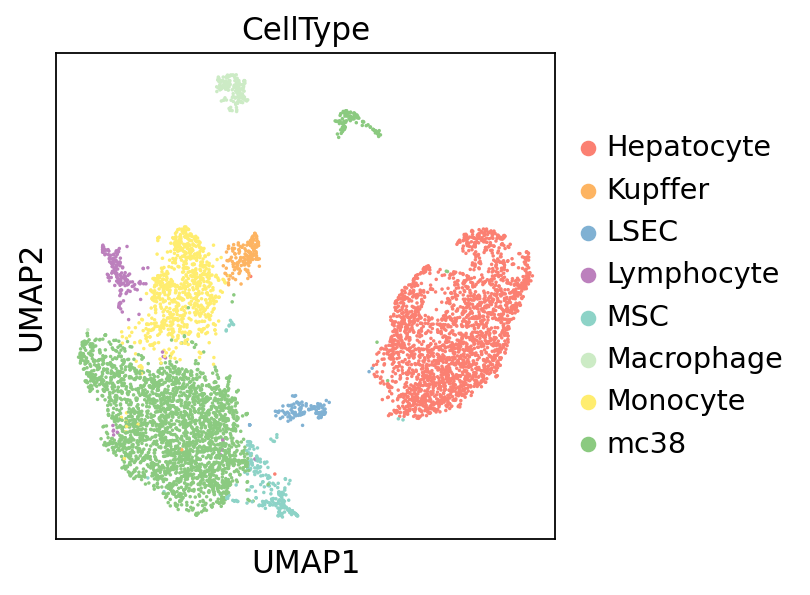

In [7]:
sc.pl.umap(adata_10x,color=['celltype'], size=10)
sc.pl.umap(adata_xyz,color=['CellType',], size=10)

In [8]:
def low_de_make(adata, p=0.2, p_of='any', cov='leiden'):
    '''
    adata = adata object with a raw attribute
    p = percentage of cells that should be expressing a gene for it to be reported
    p_of = when subsetting genes to report, at least p percent of cells in ANY cluster ('any') \n
    should be expressing the gene, or only in the provided cluster
    '''
    X = adata.raw.X.copy()
    clusts = adata.obs[cov].dtype.categories
    df = pd.DataFrame(0,index=clusts, columns=adata.raw.var_names.values,dtype=np.float16)
    for clust in clusts:
        clustbool = (adata.obs[cov] == clust).values
        clustX = X[clustbool]
        try:
            clustX = clustX.tocsc()
        except AttributeError:
            from scipy.sparse import csc_matrix
            clustX = csc_matrix(clustX)
        df.loc[clust] = clustX.getnnz(axis=0)/clustX.shape[0]
    if p_of == 'any':
        df = df.iloc[:,df.apply(lambda x: np.any(x > p), axis=0, raw=True).values]
    else:
        df = df.iloc[:,(df.loc[p_of] > p).values]
    return df

def low_de_compare(df, clust, compare=None):
    if type(compare) == type(None): 
        return (df.loc[clust]/df[~(df.index == clust)].mean()).sort_values(ascending=False)
    elif type(compare) == list:
        return (df.loc[clust].mean()/df[(df.index.isin(compare))].mean()).sort_values(ascending=False)

### Neutrophils

In [9]:
g1 = ['Neutrophil']
g2 = [i for i in adata_10x.obs['celltype'].dtype.categories if i not in g1]

In [10]:
g1 = [str(i) for i in g1]
g2 = [str(i) for i in g2]

In [12]:
df = low_de_make(adata_10x, p=0.2, p_of=g1[0], cov='celltype')

In [13]:
de_genes = low_de_compare(df, g1[0], compare=g2)

In [23]:
print(de_genes[:10])

Retnlg     1106.000000
S100a9      933.500000
S100a8      359.750000
Osm          95.062500
G0s2         46.562500
Mxd1         40.281250
Pglyrp1      36.312500
Cxcl2        13.218750
Ccrl2        13.046875
Ifitm1       10.703125
dtype: float16


In [30]:
np.intersect1d(de_genes[de_genes > 2].index, adata_xyz.var_names)

array(['Hp', 'Tyrobp'], dtype=object)

In [33]:
adata_xyz.var_names

Index(['Rims1', 'Lmbrd1', 'Il18r1', 'Dnah7b', 'Stat4', 'Adam23', 'Erbb4',
       'Spag16', 'Xrcc5', 'Igfbp2',
       ...
       'Cyp2c50', 'Cyp2c70', 'Hoga1', 'Fam178a', 'Sema4g', 'Wbp1l', 'Xpnpep1',
       'Mxi1', 'Acsl5', 'Rab11fip2'],
      dtype='object', length=764)

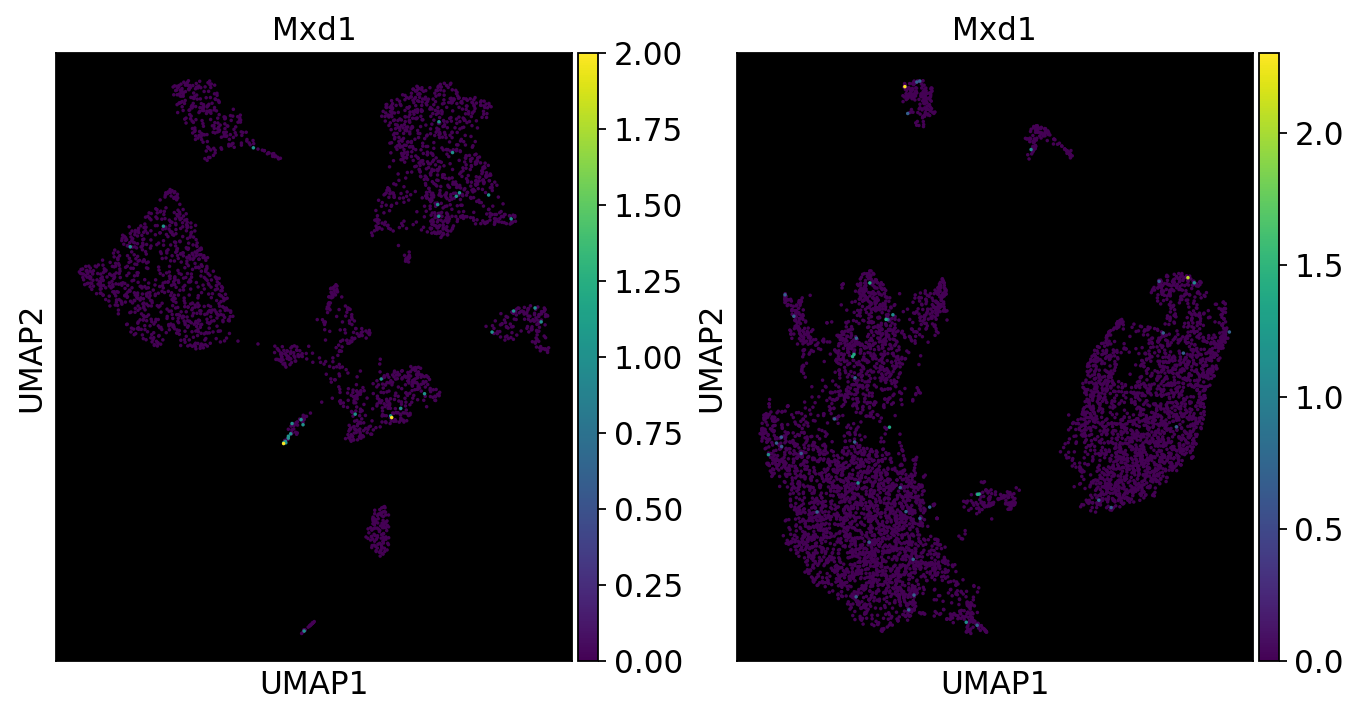

In [50]:
color= 'Mxd1'
fig, ax = plt.subplots(1, 2, figsize=(10,5))
for adata, ax in zip([adata_10x, adata_xyz], np.ravel(ax)):
    ax.set_facecolor('black')
    sc.pl.umap(adata, color=color, ax=ax, show=False, return_fig=False, size=10)

### Monocytes/Macrophages

In [62]:
g1 = ['Macrophage']
# g2 = [i for i in adata_xyz.obs['CellType'].dtype.categories if i not in g1]
g2 = ['Monocyte']

In [63]:
g1 = [str(i) for i in g1]
g2 = [str(i) for i in g2]

In [64]:
df = low_de_make(adata_xyz, p=0.2, p_of=g1[0], cov='CellType')

In [65]:
de_genes = low_de_compare(df, g1[0], compare=g2)

In [66]:
print(de_genes[:10])

Itgam-1     32.156250
Itgam       32.156250
Exoc6b       2.474609
XYLT1        2.449219
Timp2        2.421875
Kmt2d        2.322266
Rsrc1        2.251953
AY036118     2.251953
Arhgap26     2.230469
Ptp4a2       2.187500
dtype: float16


### MSC

In [76]:
g1 = ['MSC']
g2 = [i for i in adata_xyz.obs['CellType'].dtype.categories if i not in g1]
# g2 = ['Monocyte']

In [77]:
g1 = [str(i) for i in g1]
g2 = [str(i) for i in g2]

In [81]:
df = low_de_make(adata_xyz, p=0.1, p_of=g1[0], cov='CellType')

In [82]:
de_genes = low_de_compare(df, g1[0], compare=g2)

In [84]:
print(de_genes[:20])

Plekha4          20.234375
4833422C13Rik    16.843750
C1qtnf7          14.515625
Tmem108          13.640625
Fbn2             12.828125
Col15a1          11.148438
Epha3            11.039062
Pdgfrb           10.765625
Palm2            10.335938
Pde1a             9.742188
Celf4             9.125000
Reln              9.000000
Rnf150            8.679688
Tgfb3             8.593750
Clstn2            8.328125
Kcnt2             8.312500
Col14a1           8.101562
Tmtc1             7.945312
Slc24a3           7.792969
Sorbs1            7.578125
dtype: float16


In [88]:
np.intersect1d(de_genes[:20].index, adata_10x.var_names)

array(['Celf4', 'Col14a1', 'Pdgfrb', 'Tgfb3'], dtype=object)

In [33]:
adata_xyz.var_names

Index(['Rims1', 'Lmbrd1', 'Il18r1', 'Dnah7b', 'Stat4', 'Adam23', 'Erbb4',
       'Spag16', 'Xrcc5', 'Igfbp2',
       ...
       'Cyp2c50', 'Cyp2c70', 'Hoga1', 'Fam178a', 'Sema4g', 'Wbp1l', 'Xpnpep1',
       'Mxi1', 'Acsl5', 'Rab11fip2'],
      dtype='object', length=764)

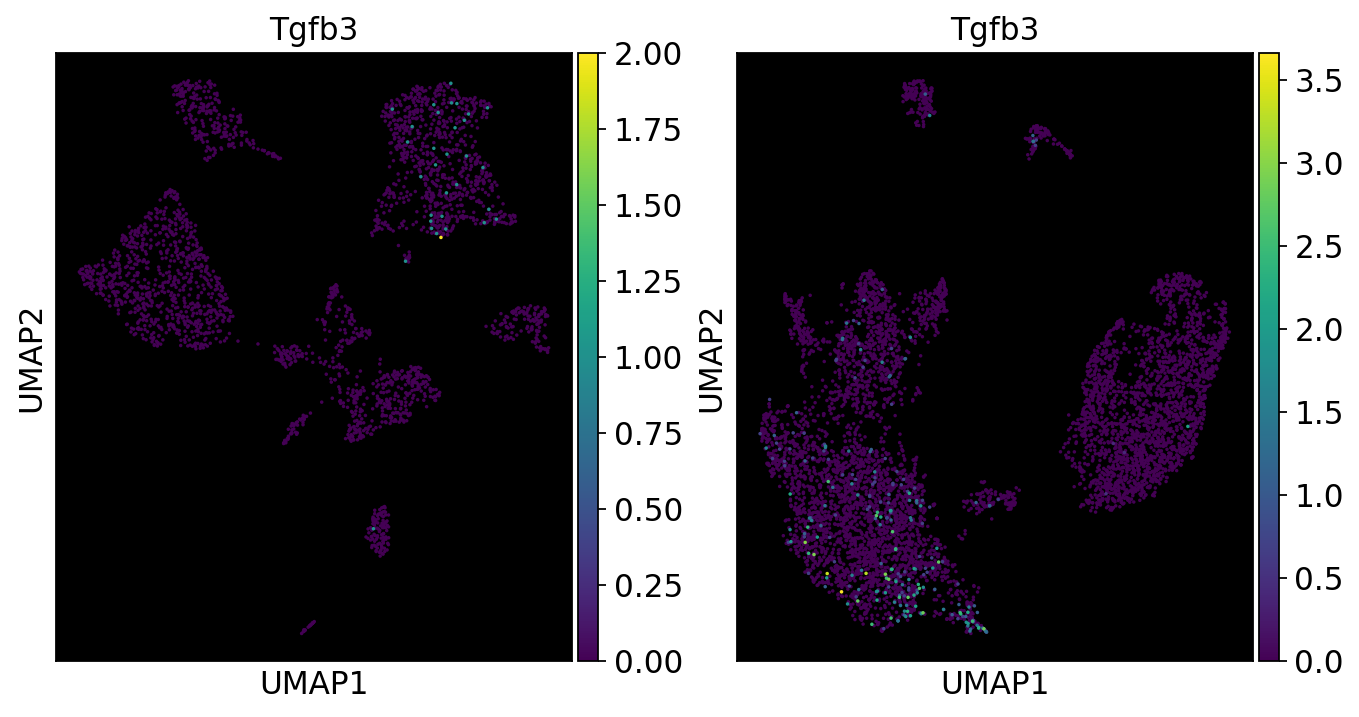

In [92]:
color= 'Tgfb3'
fig, ax = plt.subplots(1, 2, figsize=(10,5))
for adata, ax in zip([adata_10x, adata_xyz], np.ravel(ax)):
    ax.set_facecolor('black')
    sc.pl.umap(adata, color=color, ax=ax, show=False, return_fig=False, size=10)

### Kupffer

In [112]:
g1 = ['Kupffer']
g2 = [i for i in adata_xyz.obs['CellType'].dtype.categories if i not in g1]

In [113]:
g1 = [str(i) for i in g1]
g2 = [str(i) for i in g2]

In [114]:
df = low_de_make(adata_xyz, p=0.1, p_of=g1[0], cov='CellType')

In [115]:
de_genes_xyz = low_de_compare(df, g1[0], compare=g2)

In [122]:
print(de_genes_xyz[:20])

Cd5l             47.312500
Kcna2            24.562500
Slc40a1          23.359375
C6               22.343750
Clec4f           17.250000
Timd4            17.109375
Adgre4           14.257812
Ms4a8a           13.265625
Dmpk             12.859375
Marco            11.914062
Nr1h3            11.234375
AF251705         10.851562
Csf3r             9.546875
Bank1             9.117188
Gm5150            8.085938
Abcg3             7.089844
Madd              6.515625
2510009E07Rik     6.113281
Trpm2             5.796875
Fgr               5.390625
dtype: float16


In [117]:
g1 = ['Kupffer']
g2 = [i for i in adata_10x.obs['celltype'].dtype.categories if i not in g1]

In [118]:
g1 = [str(i) for i in g1]
g2 = [str(i) for i in g2]

In [119]:
df = low_de_make(adata_10x, p=0.1, p_of=g1[0], cov='celltype')

In [120]:
de_genes_10x = low_de_compare(df, g1[0], compare=g2)

In [121]:
print(de_genes_10x[:20])

Vsig4      952.500000
Clec4f     952.500000
Fabp7      190.500000
Marco      112.750000
Fcna       105.812500
Folr2       86.562500
Cd5l        71.437500
Lpl         39.593750
Col14a1     38.500000
Nr1h3       32.625000
Ramp1       28.812500
Cd300ld     28.765625
C6          26.046875
Cxcl12      23.437500
Adgre1      23.187500
Mustn1      20.578125
Slc40a1     20.218750
Plxnd1      18.890625
Hpgd        16.531250
Sh3bp5      14.921875
dtype: float16


In [125]:
np.intersect1d(de_genes_10x[de_genes_10x > 1].index, de_genes_xyz[de_genes_xyz > 1].index)

array(['Adgre1', 'Apbb1ip', 'Arpc2', 'C1qa', 'C1qb', 'C6', 'Cd5l',
       'Clec4f', 'Csf1r', 'Ctsc', 'Ddx5', 'Fcer1g', 'Gnai2', 'Gnas',
       'Itgb1', 'Laptm5', 'Lgmn', 'Ly86', 'Marcks', 'Marco', 'Mrc1',
       'Nr1h3', 'Rap1b', 'Sdc3', 'Sirpa', 'Slc40a1', 'Spi1', 'St3gal5',
       'Tln1', 'Tpr', 'Unc93b1'], dtype=object)

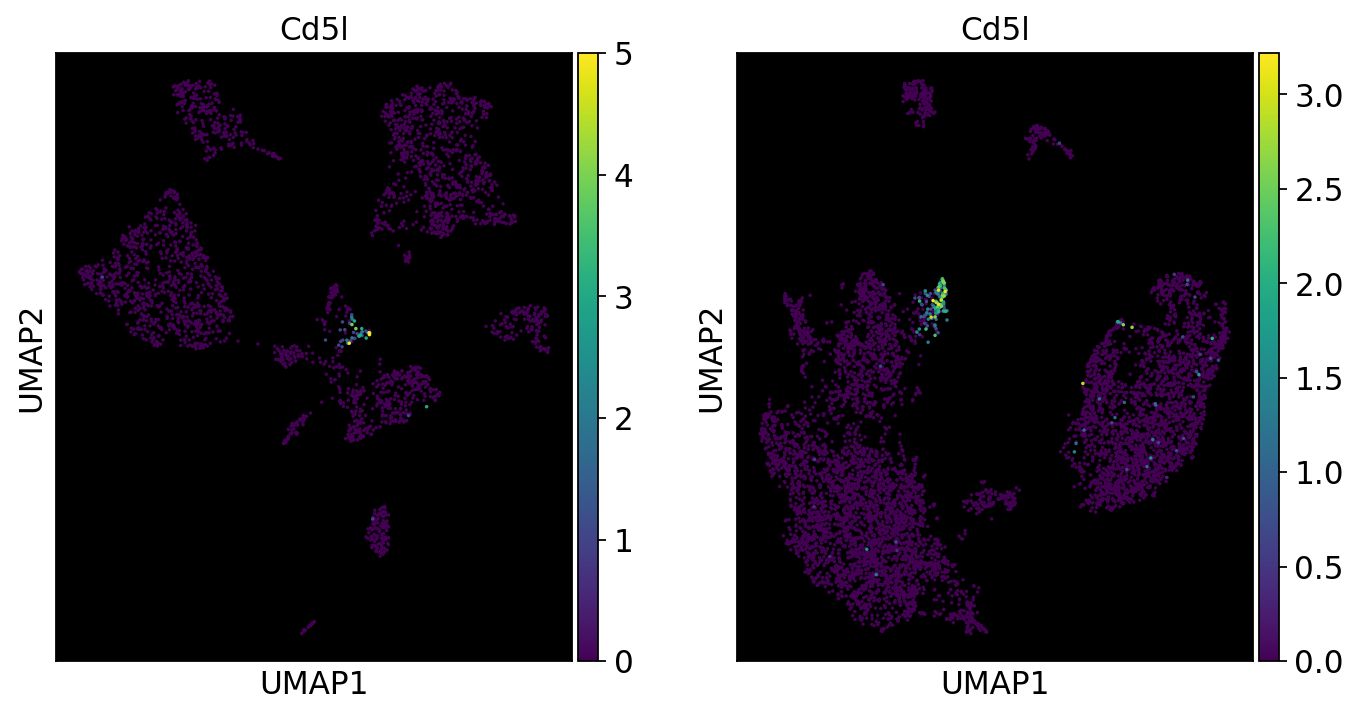

In [107]:
color= 'Cd5l'
fig, ax = plt.subplots(1, 2, figsize=(10,5))
for adata, ax in zip([adata_10x, adata_xyz], np.ravel(ax)):
    ax.set_facecolor('black')
    sc.pl.umap(adata, color=color, ax=ax, show=False, return_fig=False, size=10)

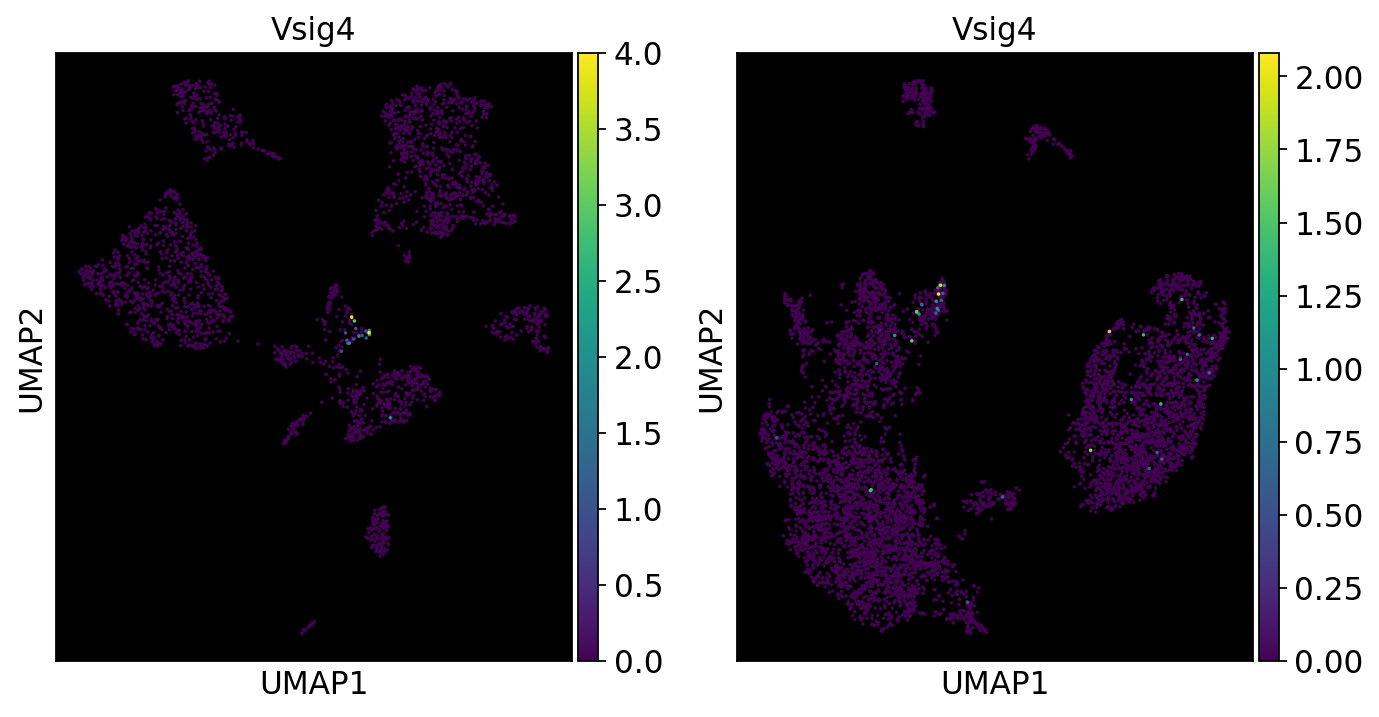

In [109]:
color= 'Vsig4'
fig, ax = plt.subplots(1, 2, figsize=(10,5))
for adata, ax in zip([adata_10x, adata_xyz], np.ravel(ax)):
    ax.set_facecolor('black')
    sc.pl.umap(adata, color=color, ax=ax, show=False, return_fig=False, size=10)

### LSEC

In [126]:
g1 = ['LSEC']
g2 = [i for i in adata_xyz.obs['CellType'].dtype.categories if i not in g1]

In [127]:
g1 = [str(i) for i in g1]
g2 = [str(i) for i in g2]

In [128]:
df = low_de_make(adata_xyz, p=0.1, p_of=g1[0], cov='CellType')

In [129]:
de_genes_xyz = low_de_compare(df, g1[0], compare=g2)

In [130]:
print(de_genes_xyz[:20])

Tie1             115.937500
Egfl7             79.187500
Flt4              41.156250
Ushbp1            35.625000
Kdr               29.296875
Rasgrp3           28.718750
Adgrl4            23.890625
Cyyr1             19.906250
Tek               19.375000
Adgrf5            18.171875
Adam23            14.398438
4930448N21Rik     13.820312
Cd55              13.468750
Ptprb             12.632812
Dock6             11.906250
Fgd5              11.828125
F8                 9.015625
Trp53i11           8.851562
Slco2a1            8.375000
Pdgfd              8.320312
dtype: float16


In [131]:
g1 = ['LSEC']
g2 = [i for i in adata_10x.obs['celltype'].dtype.categories if i not in g1]

In [132]:
g1 = [str(i) for i in g1]
g2 = [str(i) for i in g2]

In [133]:
df = low_de_make(adata_10x, p=0.1, p_of=g1[0], cov='celltype')

In [134]:
de_genes_10x = low_de_compare(df, g1[0], compare=g2)

In [135]:
print(de_genes_10x[:20])

Gpihbp1     49.312500
Fam167b     49.156250
Sash1       43.468750
Arhgap23    33.437500
Gpr182      32.468750
Hivep3      32.375000
Ephb4       31.875000
Cd36        30.875000
Clec4g      27.171875
Stab2       26.734375
Dnase1l3    26.734375
Emilin1     22.859375
Fabp4       21.875000
Dpp4        21.203125
Plpp3       19.093750
Amotl1      18.609375
Mylip       18.609375
Smagp       18.453125
Plxnd1      18.296875
Ramp2       18.250000
dtype: float16


In [138]:
np.intersect1d(de_genes_10x[:30].index, de_genes_xyz[:30].index)

array(['Egfl7', 'Eng'], dtype=object)

In [136]:
np.intersect1d(de_genes_10x[de_genes_10x > 1].index, de_genes_xyz[de_genes_xyz > 1].index)

array(['Amotl1', 'Arhgap23', 'Cd55', 'Cdc42bpb', 'Clic4', 'Col4a1',
       'Csnk1a1', 'Egfl7', 'Eng', 'Ets1', 'Fyn', 'Gnai2', 'Gnb1',
       'Hivep3', 'Igfbp4', 'Igfbp7', 'Il6st', 'Itgb1', 'Jak1', 'Kdr',
       'Lifr', 'Maf', 'Mrc1', 'Phf20l1', 'Plpp1', 'Plpp3', 'Plxnd1',
       'Ptprb', 'Rtn4', 'Sash1', 'Stab2'], dtype=object)

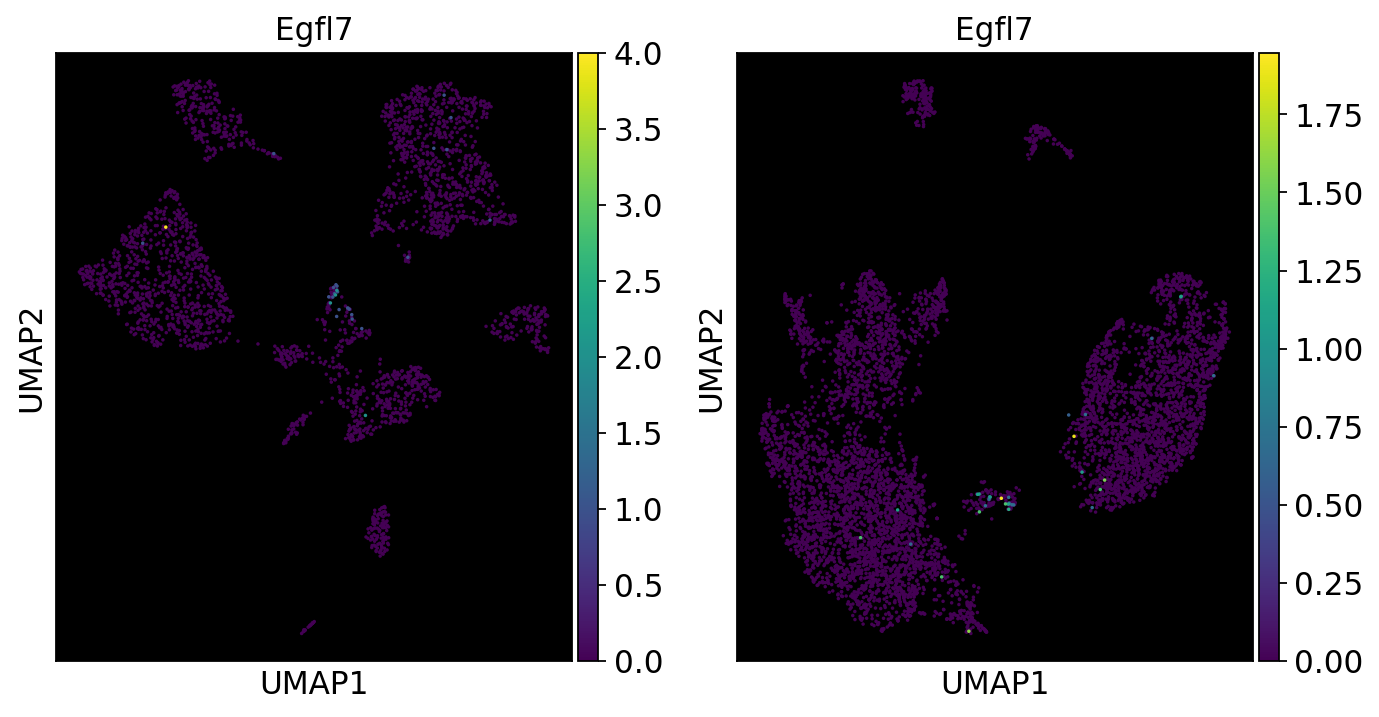

In [139]:
color= 'Egfl7'
fig, ax = plt.subplots(1, 2, figsize=(10,5))
for adata, ax in zip([adata_10x, adata_xyz], np.ravel(ax)):
    ax.set_facecolor('black')
    sc.pl.umap(adata, color=color, ax=ax, show=False, return_fig=False, size=10)

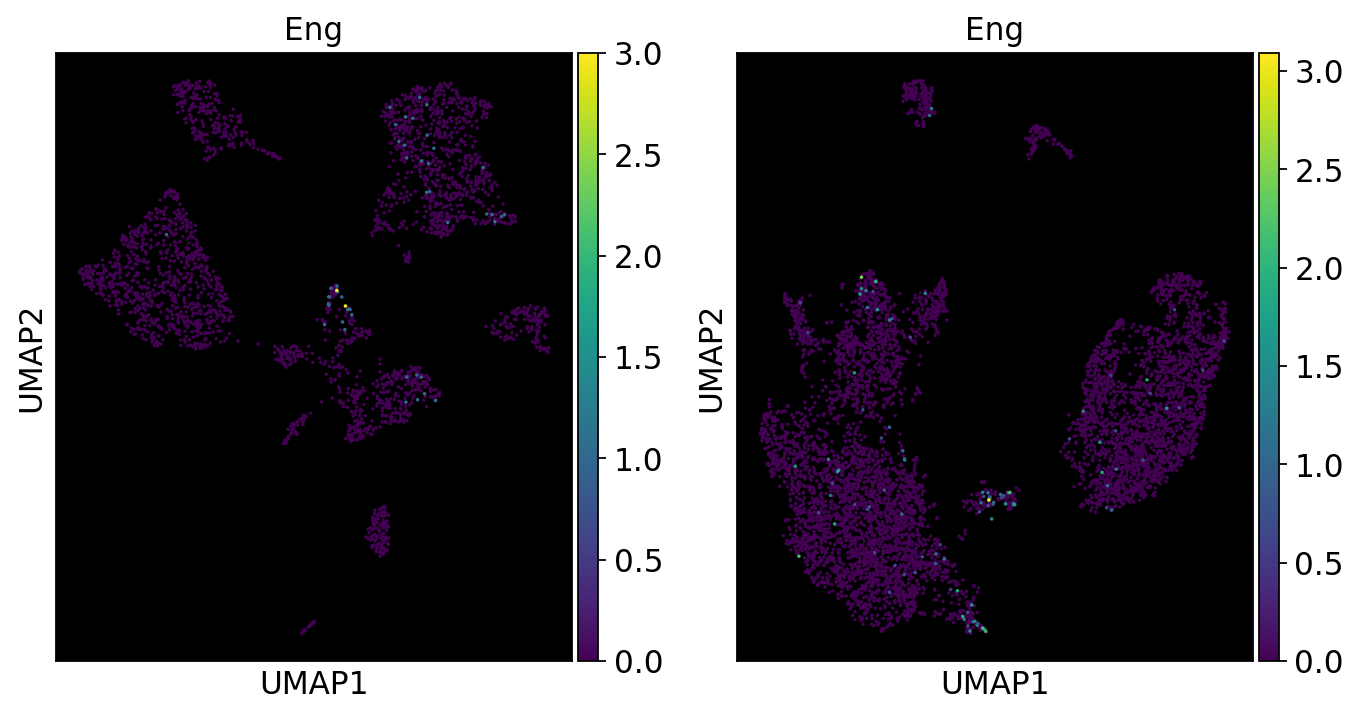

In [140]:
color= 'Eng'
fig, ax = plt.subplots(1, 2, figsize=(10,5))
for adata, ax in zip([adata_10x, adata_xyz], np.ravel(ax)):
    ax.set_facecolor('black')
    sc.pl.umap(adata, color=color, ax=ax, show=False, return_fig=False, size=10)

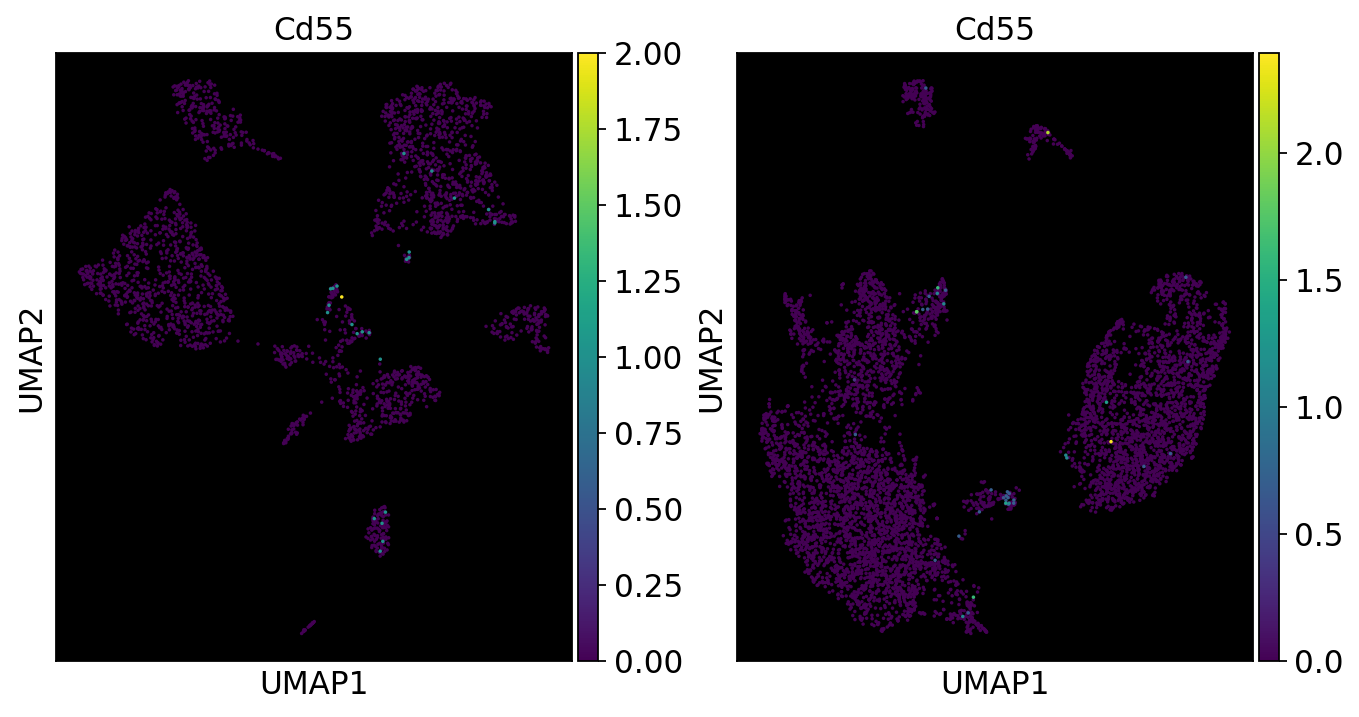

In [141]:
color= 'Cd55'
fig, ax = plt.subplots(1, 2, figsize=(10,5))
for adata, ax in zip([adata_10x, adata_xyz], np.ravel(ax)):
    ax.set_facecolor('black')
    sc.pl.umap(adata, color=color, ax=ax, show=False, return_fig=False, size=10)

### Lymphocytes

In [142]:
g1 = ['Lymphocyte']
g2 = [i for i in adata_xyz.obs['CellType'].dtype.categories if i not in g1]

In [143]:
g1 = [str(i) for i in g1]
g2 = [str(i) for i in g2]

In [144]:
df = low_de_make(adata_xyz, p=0.1, p_of=g1[0], cov='CellType')

In [145]:
de_genes_xyz = low_de_compare(df, g1[0], compare=g2)

In [161]:
print(de_genes_xyz[:10])

Bcl11b     28.593750
Il18r1     16.812500
Lck        16.781250
Stat4      15.500000
Fam102a    14.250000
Gimap4     13.914062
Itk        13.289062
Ikzf3      13.085938
Ms4a4b     12.820312
Satb1      12.476562
dtype: float16


In [156]:
g1 = ['T Cell']
g2 = [i for i in adata_10x.obs['celltype'].dtype.categories if i not in g1]

In [157]:
g1 = [str(i) for i in g1]
g2 = [str(i) for i in g2]

In [158]:
df = low_de_make(adata_10x, p=0.1, p_of=g1[0], cov='celltype')

In [159]:
de_genes_10x = low_de_compare(df, g1[0], compare=g2)

In [162]:
print(de_genes_10x[:10])

Trgv2         inf
Skap1         inf
Tnfrsf9       inf
Cd3g       1243.0
Trbv17      997.5
Gzmb        712.0
Gzmk        712.0
Cxcr6       712.0
Cd8a        415.5
Cd3d        356.0
dtype: float16


In [163]:
g1 = ['B Cell']
g2 = [i for i in adata_10x.obs['celltype'].dtype.categories if i not in g1]

In [164]:
g1 = [str(i) for i in g1]
g2 = [str(i) for i in g2]

In [165]:
df = low_de_make(adata_10x, p=0.1, p_of=g1[0], cov='celltype')

In [166]:
de_genes_10x = low_de_compare(df, g1[0], compare=g2)

In [167]:
print(de_genes_10x[:10])

Fcmr              inf
Ms4a1      370.500000
H2-DMb2    100.625000
Ccr7        94.875000
H2-Ob       57.968750
Ebf1        38.281250
Ighm        22.578125
Cd83        11.539062
Napsa       11.226562
Cnp          9.914062
dtype: float16


In [138]:
np.intersect1d(de_genes_10x[:30].index, de_genes_xyz[:30].index)

array(['Egfl7', 'Eng'], dtype=object)

In [136]:
np.intersect1d(de_genes_10x[de_genes_10x > 1].index, de_genes_xyz[de_genes_xyz > 1].index)

array(['Amotl1', 'Arhgap23', 'Cd55', 'Cdc42bpb', 'Clic4', 'Col4a1',
       'Csnk1a1', 'Egfl7', 'Eng', 'Ets1', 'Fyn', 'Gnai2', 'Gnb1',
       'Hivep3', 'Igfbp4', 'Igfbp7', 'Il6st', 'Itgb1', 'Jak1', 'Kdr',
       'Lifr', 'Maf', 'Mrc1', 'Phf20l1', 'Plpp1', 'Plpp3', 'Plxnd1',
       'Ptprb', 'Rtn4', 'Sash1', 'Stab2'], dtype=object)

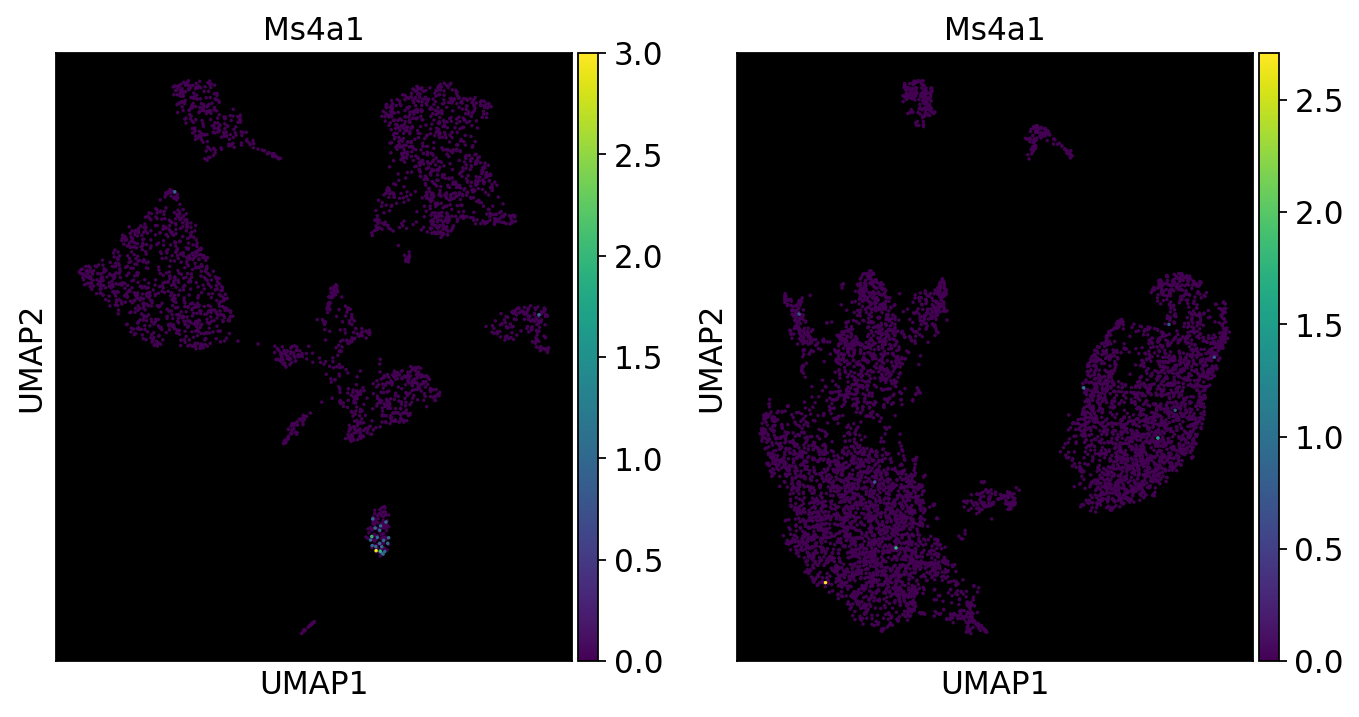

In [168]:
color= 'Ms4a1'
fig, ax = plt.subplots(1, 2, figsize=(10,5))
for adata, ax in zip([adata_10x, adata_xyz], np.ravel(ax)):
    ax.set_facecolor('black')
    sc.pl.umap(adata, color=color, ax=ax, show=False, return_fig=False, size=10)

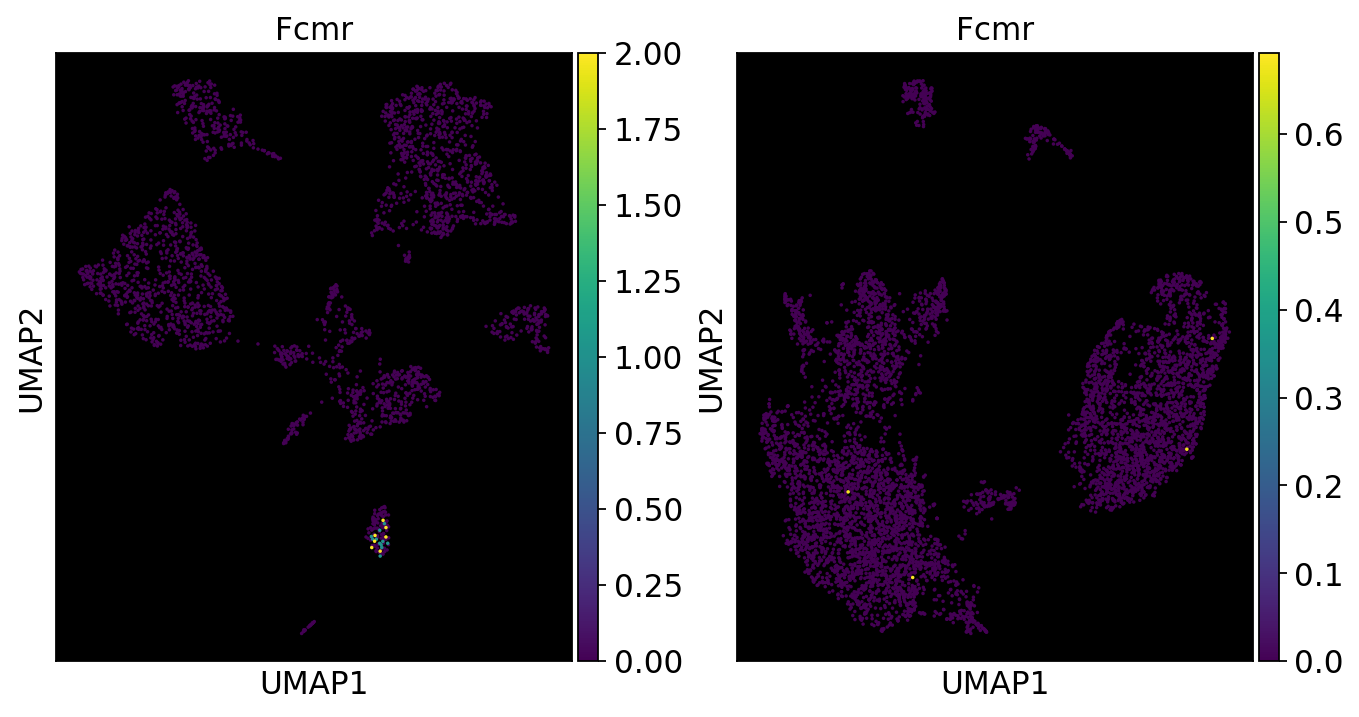

In [172]:
color= 'Fcmr'
fig, ax = plt.subplots(1, 2, figsize=(10,5))
for adata, ax in zip([adata_10x, adata_xyz], np.ravel(ax)):
    ax.set_facecolor('black')
    sc.pl.umap(adata, color=color, ax=ax, show=False, return_fig=False, size=10)

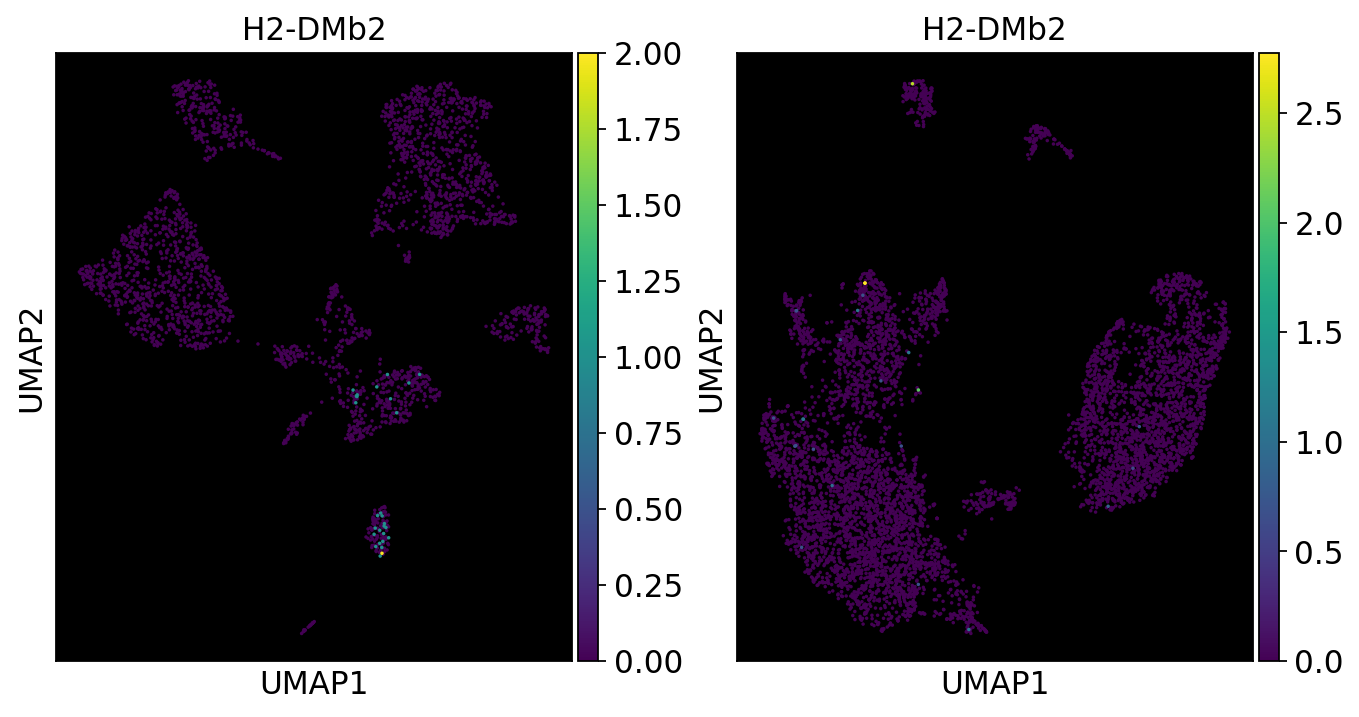

In [173]:
color= 'H2-DMb2'
fig, ax = plt.subplots(1, 2, figsize=(10,5))
for adata, ax in zip([adata_10x, adata_xyz], np.ravel(ax)):
    ax.set_facecolor('black')
    sc.pl.umap(adata, color=color, ax=ax, show=False, return_fig=False, size=10)

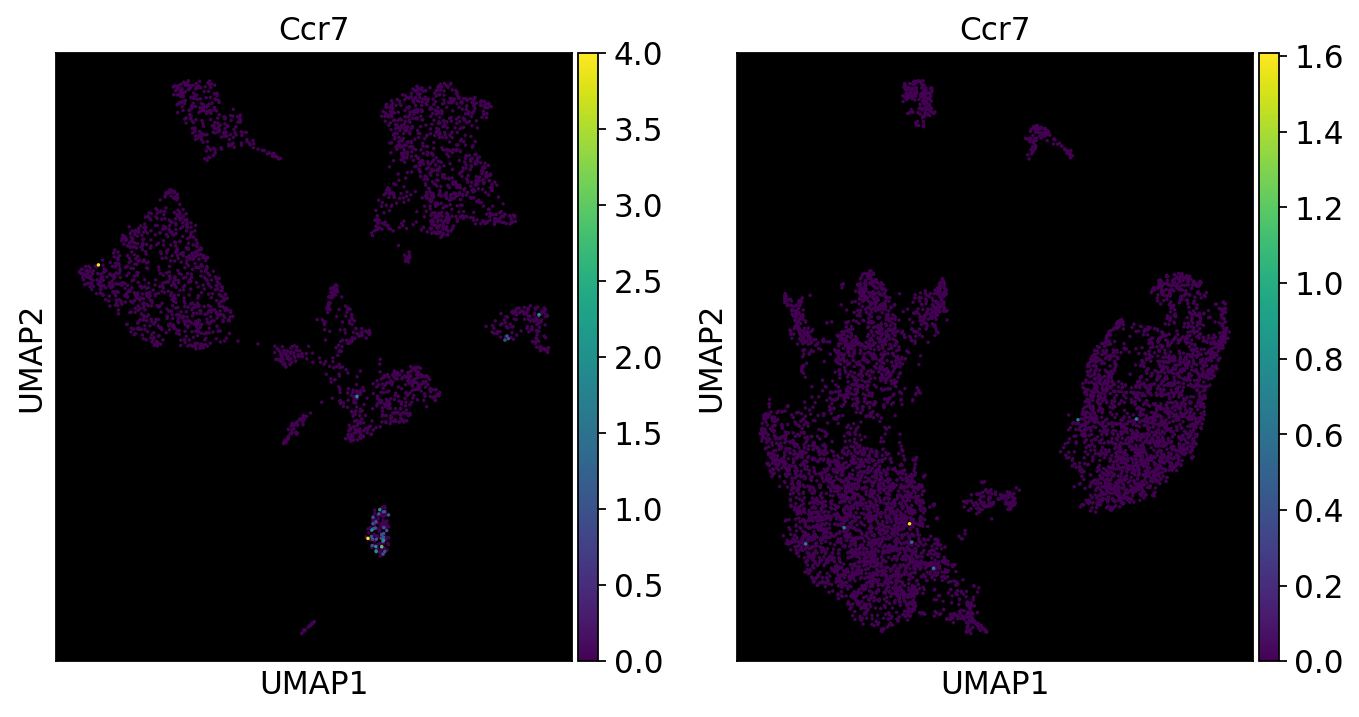

In [174]:
color= 'Ccr7'
fig, ax = plt.subplots(1, 2, figsize=(10,5))
for adata, ax in zip([adata_10x, adata_xyz], np.ravel(ax)):
    ax.set_facecolor('black')
    sc.pl.umap(adata, color=color, ax=ax, show=False, return_fig=False, size=10)

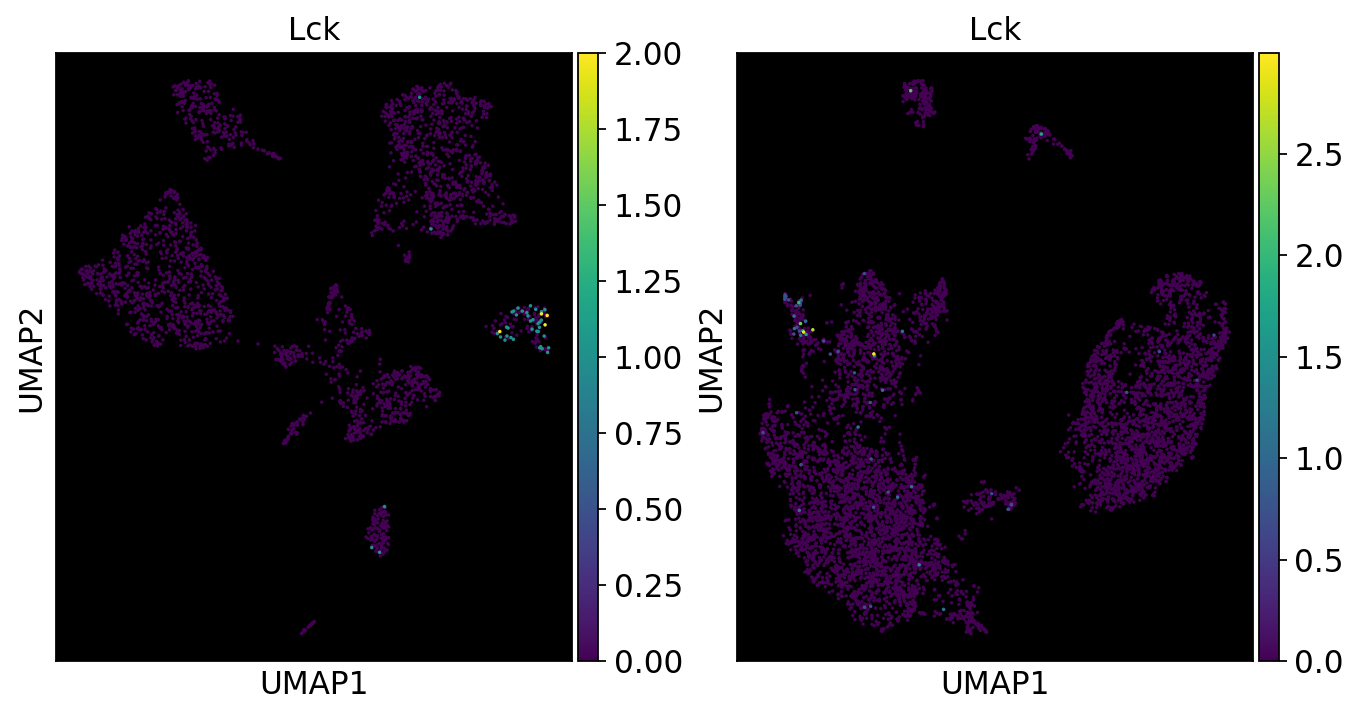

In [171]:
color= 'Lck'
fig, ax = plt.subplots(1, 2, figsize=(10,5))
for adata, ax in zip([adata_10x, adata_xyz], np.ravel(ax)):
    ax.set_facecolor('black')
    sc.pl.umap(adata, color=color, ax=ax, show=False, return_fig=False, size=10)

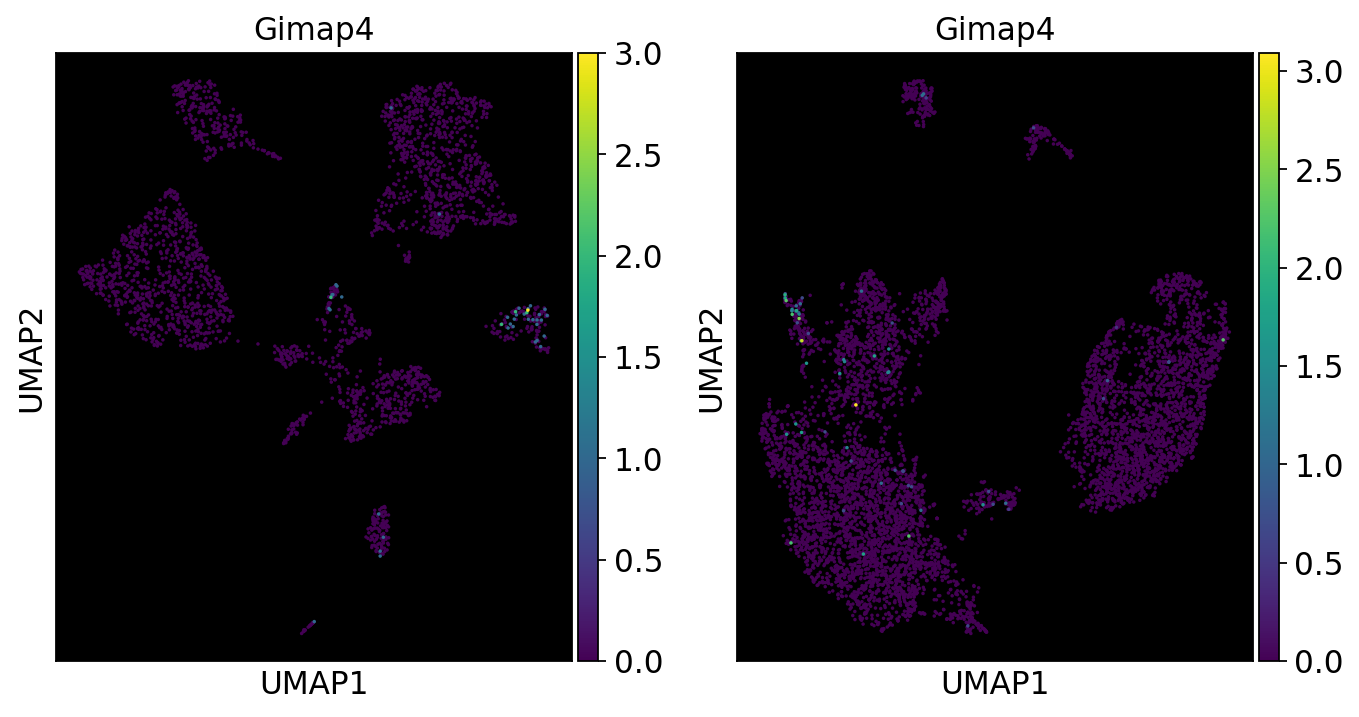

In [177]:
color= 'Gimap4'
fig, ax = plt.subplots(1, 2, figsize=(10,5))
for adata, ax in zip([adata_10x, adata_xyz], np.ravel(ax)):
    ax.set_facecolor('black')
    sc.pl.umap(adata, color=color, ax=ax, show=False, return_fig=False, size=10)

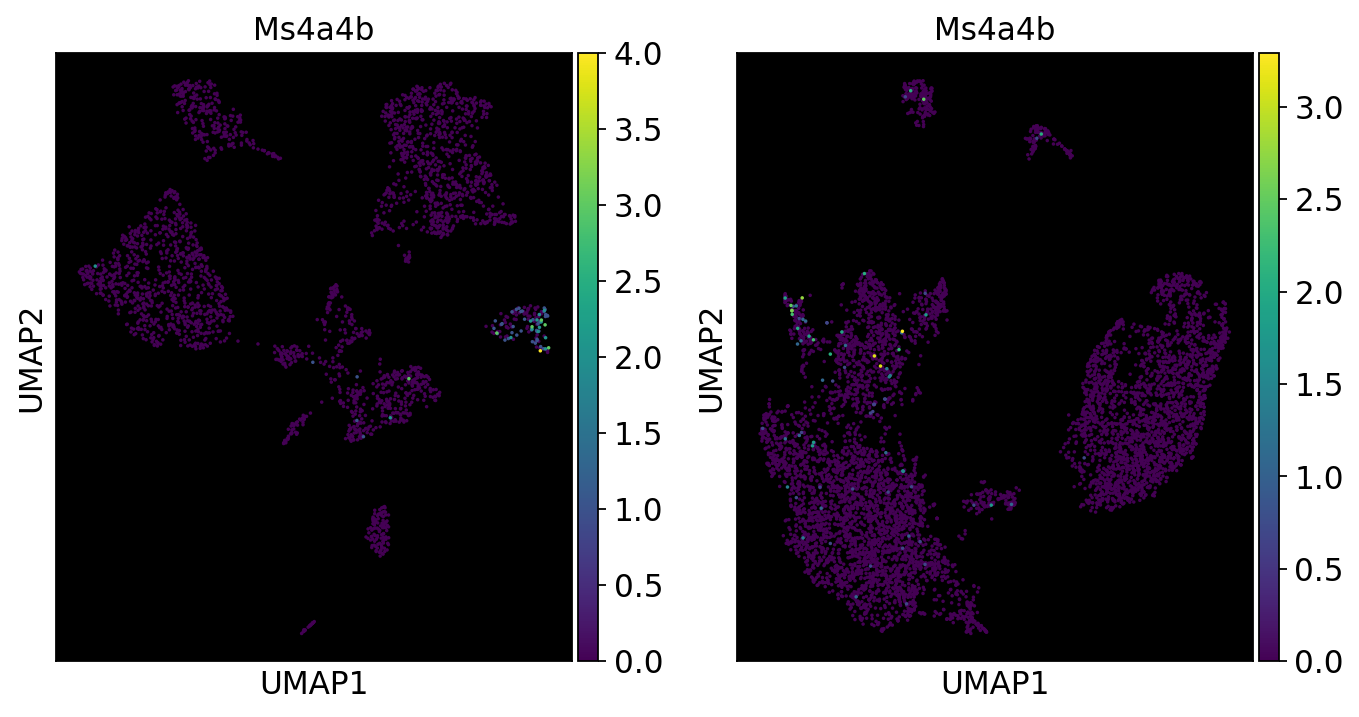

In [180]:
color= 'Ms4a4b'
fig, ax = plt.subplots(1, 2, figsize=(10,5))
for adata, ax in zip([adata_10x, adata_xyz], np.ravel(ax)):
    ax.set_facecolor('black')
    sc.pl.umap(adata, color=color, ax=ax, show=False, return_fig=False, size=10)

### MC38

In [76]:
g1 = ['mc38']
g2 = [i for i in adata_xyz.obs['CellType'].dtype.categories if i not in g1]
# g2 = ['Monocyte']

In [77]:
g1 = [str(i) for i in g1]
g2 = [str(i) for i in g2]

In [81]:
df = low_de_make(adata_xyz, p=0.1, p_of=g1[0], cov='CellType')

In [82]:
de_genes = low_de_compare(df, g1[0], compare=g2)

In [84]:
print(de_genes[:20])

Plekha4          20.234375
4833422C13Rik    16.843750
C1qtnf7          14.515625
Tmem108          13.640625
Fbn2             12.828125
Col15a1          11.148438
Epha3            11.039062
Pdgfrb           10.765625
Palm2            10.335938
Pde1a             9.742188
Celf4             9.125000
Reln              9.000000
Rnf150            8.679688
Tgfb3             8.593750
Clstn2            8.328125
Kcnt2             8.312500
Col14a1           8.101562
Tmtc1             7.945312
Slc24a3           7.792969
Sorbs1            7.578125
dtype: float16


In [88]:
np.intersect1d(de_genes[:20].index, adata_10x.var_names)

array(['Celf4', 'Col14a1', 'Pdgfrb', 'Tgfb3'], dtype=object)

In [33]:
adata_xyz.var_names

Index(['Rims1', 'Lmbrd1', 'Il18r1', 'Dnah7b', 'Stat4', 'Adam23', 'Erbb4',
       'Spag16', 'Xrcc5', 'Igfbp2',
       ...
       'Cyp2c50', 'Cyp2c70', 'Hoga1', 'Fam178a', 'Sema4g', 'Wbp1l', 'Xpnpep1',
       'Mxi1', 'Acsl5', 'Rab11fip2'],
      dtype='object', length=764)

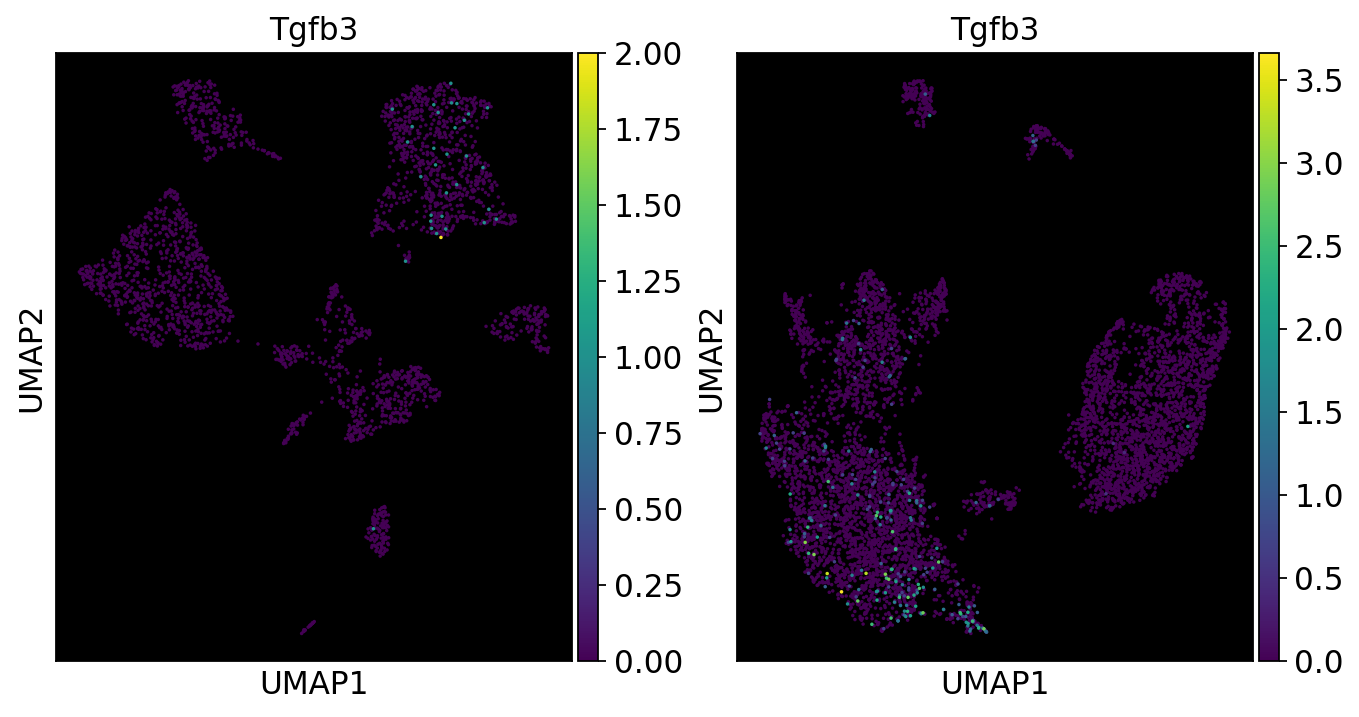

In [92]:
color= 'Tgfb3'
fig, ax = plt.subplots(1, 2, figsize=(10,5))
for adata, ax in zip([adata_10x, adata_xyz], np.ravel(ax)):
    ax.set_facecolor('black')
    sc.pl.umap(adata, color=color, ax=ax, show=False, return_fig=False, size=10)